### TIME SERIES ANALYSIS
Goal: Find outliers, trends and periodicity in the MTA turnstyle data

Data:

MTA subway fares: It is a complete dataset of rides logged by card swipes for 600 Manhattan stations.
The data was organized by Sina Kashuk at CUSP.
It contains 23 different subway card types (e.g. monthly pass, daily pass, Act for Disability pass…) as follows

Populating the interactive namespace from numpy and matplotlib


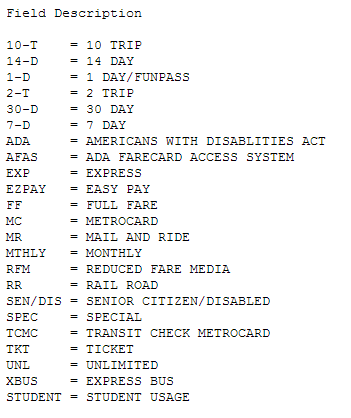

In [17]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
import os

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes-Copy1.png")

In [2]:
mta = np.load('MTA_Fare-Copy1.npy')

In [82]:
mta.shape

(600, 23, 194)

In [3]:
#convert missing values of -1 to nan
mta = mta.astype('float')
mta[mta == -1] = np.nan

# Task 4:
Several stations show a prominent annual periodicity. Identify the 4 stations (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [4]:
# We want each station as the index
mta = np.nansum(mta,axis=1)

In [5]:
mta.shape

(600, 194)

In [89]:
52*3

156

In [7]:
# make into dataframe so we can add the periodicity
df_mta52 = pd.DataFrame.from_records(mta)

In [8]:
df_mta52.shape

(600, 194)

In [22]:
df_mta52.T.shape

(194, 600)

In [23]:
# we want to standardize along each station. Subtract mean/divide by std
df_mta52_st = ((df_mta52.T - df_mta52.mean(1)) / df_mta52.std(1)).T

In [58]:
len(df_mta52_st)

600

In [65]:
# check to see that the mean is super small
totalmean = []
eachMean = []
for i in range((len(df_mta52_st.T))):
    print(df_mta52_st[i].mean())
    eachMean.append(df_mta52_st[i].mean())
    totalmean =  sum(eachMean)

-0.756953420523
-0.206078731389
-0.119528429142
-0.154796965623
-0.179730935256
-0.844665771549
-0.348527338463
-0.277313057097
-0.336525241259
-0.359590150644
-0.402526499938
-0.49531206603
-0.648154879567
-0.355523948142
-0.723701006118
-0.0185423666599
-0.0047673867859
-0.309861960869
0.00834939160936
-0.227844947425
0.0444223889798
0.000376353546291
-0.0503595238964
-0.0338582776145
-0.00273449350658
-1.12479158017
-0.236507576117
0.0336474621387
-0.100069197206
-0.611537059701
-1.83568370722
-1.83759391419
-0.580119145541
-0.601050655266
-0.876708763959
-0.791241582736
-0.204937880645
-0.129435813789
-0.0239887215968
-0.766192888035
-0.114804004351
-0.0753542248563
0.00665637752371
-0.0543649322015
-0.110082049453
0.039594509575
0.0385454123261
-0.458798616318
-0.288918083901
0.09246006627
-0.0534655332536
-0.022896394229
-0.602140358341
0.00230509163775
0.0230679764923
-0.0120693015554
0.0849296730636
-0.717845426141
0.0108458835268
-0.132051880972
-0.204590410364
-0.141576519288

In [75]:
# check that std is 1
totalStd = []
eachStd = []
for i in range((len(df_mta52_st.T))):
    eachStd.append(df_mta52_st[i].std())
    totalStd =  np.mean(eachStd)

In [77]:
totalStd

0.64483475262694567

This is pretty close to one for the average of each observation, hopefully this is okay for our transformation.

We standardize along each observation, because it is a time series and the features are not independent.

In [ ]:
# we might want to drop na, do it here if we look back and want to

In [78]:
# Lets turn it back into an array to look at in Fourier Space 
mta_ar52 = pd.DataFrame.as_matrix(df_mta52_st)

In [79]:
mta_ar52.shape

(600, 194)

97.0


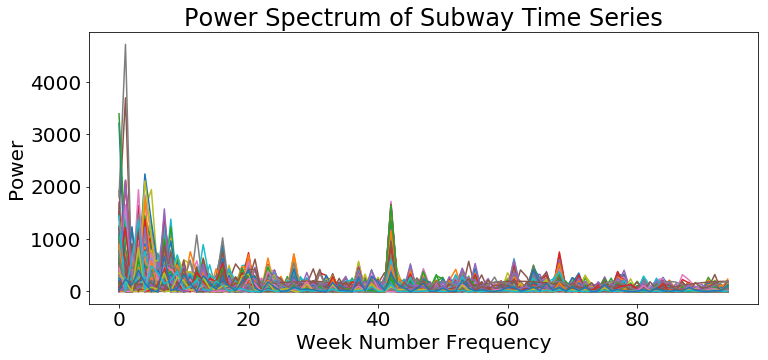

In [183]:
print(len(mta_ar52[1])/2)
pl.figure(figsize=(12,5))
for i in range(len(mta_ar52)):
    fr=np.square((np.fft.rfft(mta_ar52[i]).real))
    pl.plot(fr[3:])
    #pl.xlim(xmax=52)
    pl.xlabel("Week Number Frequency")
    pl.title ("Power Spectrum of Subway Time Series")
    pl.ylabel("Power")

The x axis is the frequency,it runs from 0 (period of 0 weeks) to the maximum frequency which is 1/2 the number of samples from 194 weeks: 97 here. That is because I need at least 2 points to describe a pattern.

We will then use this to find the period. Which is 1/frequency so we can interpret it with regard to the annual periodicity.

# Now let's look for the freqency of 1 year
This will allow us to find which stations have the most periodic trend for a 1 year period.

In [102]:
Nd=len(mta_ar52[1])

In [92]:
Nd

194

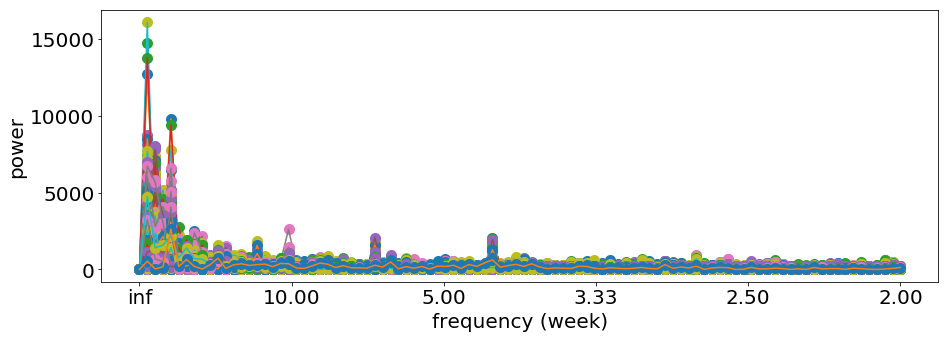

In [127]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(len(mta_ar52)):
    f = np.abs(np.fft.rfft(mta_ar52[i]))**2
    ax.plot(np.fft.rfftfreq(Nd, 1.0), (f), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(Nd, 1.0), (f), '-')
    ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.ylabel("power", fontsize=20)
pl.xlabel("Frequency (week)", fontsize=20);

In [128]:
print (" The first two frequency (slowest) caculated are \n1: infinity (1.0/0) ",
       "and \n2:the frequency corresponding to the entire duration of the series = N*d,"
       " \nand they should be removed because they are uninteresting\n",
       "freq: ", np.fft.rfftfreq(Nd, 1.0)[0], "= period: ", 1.0/np.fft.rfftfreq(Nd, 1.0)[0], "and\n",
       "freq: ", np.fft.rfftfreq(Nd, 1.0)[1], "= period: every %.1f"%(1.0/np.fft.rfftfreq(Nd, 1.0)[1]), "weeks\n\n")

print ("The fastest frequency you can calculate is every 1.0/2*d, "
       "called the Nyquist frequency\n",
       np.fft.rfftfreq(Nd, 1.0)[-1],  "or every %.1f"%(1.0/np.fft.rfftfreq(Nd, 1.0)[-1]), "weeks")

 The first two frequency (slowest) caculated are 
1: infinity (1.0/0)  and 
2:the frequency corresponding to the entire duration of the series = N*d, 
and they should be removed because they are uninteresting
 freq:  0.0 = period:  inf and
 freq:  0.00515463917526 = period: every 194.0 weeks


The fastest frequency you can calculate is every 1.0/2*d, called the Nyquist frequency
 0.5 or every 2.0 weeks


Now lets look at the power spectrum in period. 

We remove the first entry of the FFT output array because, as explained above, it is not interesting because this shows how the period matches on itself and is therefore always a very large number. By plotting the points [1:], i.e. the FFT omitting its first value, i can see what happens much better, since the high value at [0] was forcing the y range in the plot to be very large.

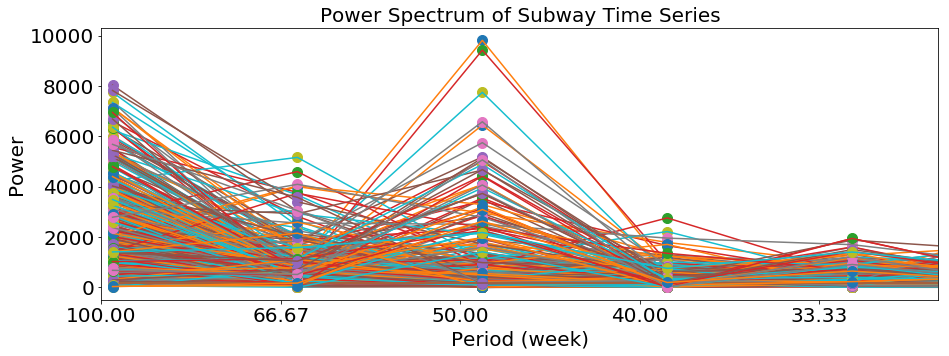

In [150]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(len(mta_ar52)):
    f = np.abs(np.fft.rfft(mta_ar52[i]))**2
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%.2f"%(1/f) for f in ax.get_xticks()], fontsize=20)
    ax.set_xlim(0.01,1.0/30) # we set the limit to see at the 52 week period
pl.ylabel("Power", fontsize=20)
pl.xlabel("Period (week)", fontsize=20);
pl.title("Power Spectrum of Subway Time Series", fontsize=20);

In [ ]:
# By changing the ratio of the x tick labels we can divide the period into weeks, months days

# Look at it in terms of Month

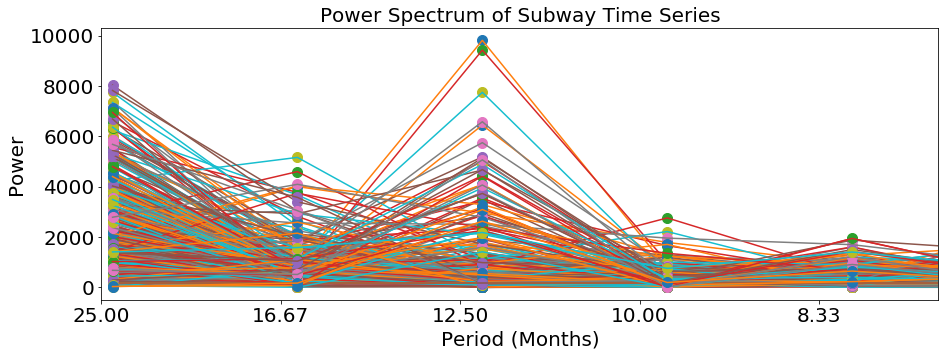

In [151]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(len(mta_ar52)):
    f = np.abs(np.fft.rfft(mta_ar52[i]))**2
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%.2f"%(1/4./f) for f in ax.get_xticks()], fontsize=20)
    ax.set_xlim(0.01,1.0/30) # we set the limit to see at the 52 week period
pl.ylabel("Power", fontsize=20)
pl.xlabel("Period (Months)", fontsize=20);
pl.title("Power Spectrum of Subway Time Series", fontsize=20);

# Look in terms of Day

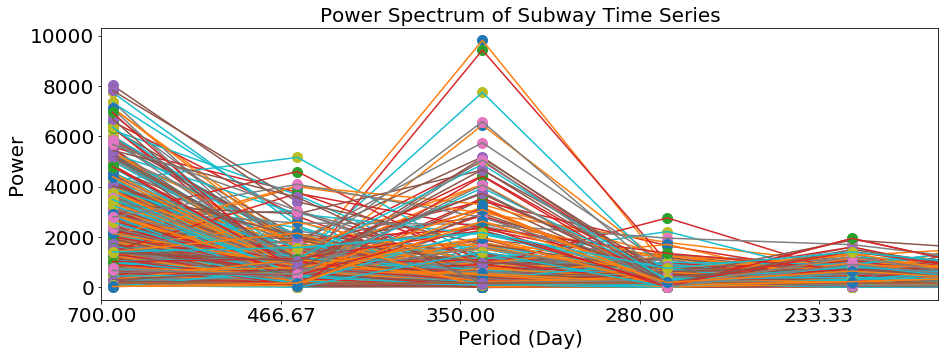

In [152]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(len(mta_ar52)):
    f = np.abs(np.fft.rfft(mta_ar52[i]))**2
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%.2f"%(1*7./f) for f in ax.get_xticks()], fontsize=20)
    ax.set_xlim(0.01,1.0/30) # we set the limit to see at the 52 week period
pl.ylabel("Power", fontsize=20)
pl.xlabel("Period (Day)", fontsize=20);
pl.title("Power Spectrum of Subway Time Series", fontsize=20);

# Look in terms of Hours? This is silly but just to understand the x axis labels.

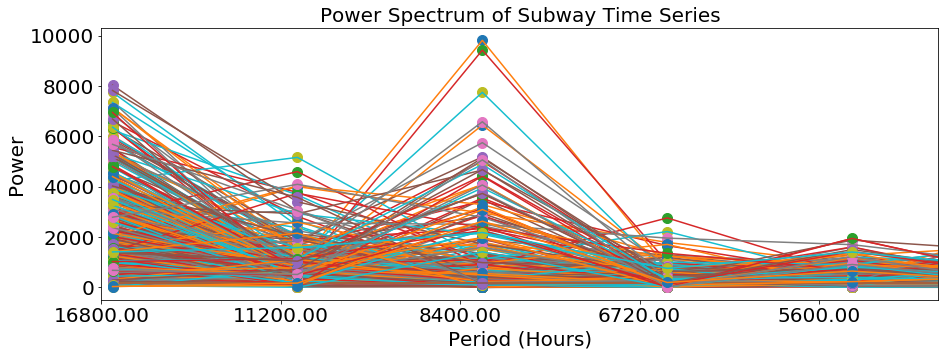

In [157]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for i in range(len(mta_ar52)):
    f = np.abs(np.fft.rfft(mta_ar52[i]))**2
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(Nd, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%.2f"%(1*7*24./f) for f in ax.get_xticks()], fontsize=20)
    ax.set_xlim(0.01,1.0/30) # we set the limit to see at the 52 week period
pl.ylabel("Power", fontsize=20)
pl.xlabel("Period (Hours)", fontsize=20);
pl.title("Power Spectrum of Subway Time Series", fontsize=20);

No matter how we break down the period, we see the spike at about a year. Here there are 8760 in a year.

# But we are looking for perioidicty of one year, so lets see what this frequency would look like

In [195]:
#frequency of 52 weeks
1/52

0.019230769230769232

In [187]:
fr=np.fft.rfftfreq(Nd, 1.0)

In [218]:
fr

array([ 0.        ,  0.00515464,  0.01030928,  0.01546392,  0.02061856,
        0.0257732 ,  0.03092784,  0.03608247,  0.04123711,  0.04639175,
        0.05154639,  0.05670103,  0.06185567,  0.06701031,  0.07216495,
        0.07731959,  0.08247423,  0.08762887,  0.09278351,  0.09793814,
        0.10309278,  0.10824742,  0.11340206,  0.1185567 ,  0.12371134,
        0.12886598,  0.13402062,  0.13917526,  0.1443299 ,  0.14948454,
        0.15463918,  0.15979381,  0.16494845,  0.17010309,  0.17525773,
        0.18041237,  0.18556701,  0.19072165,  0.19587629,  0.20103093,
        0.20618557,  0.21134021,  0.21649485,  0.22164948,  0.22680412,
        0.23195876,  0.2371134 ,  0.24226804,  0.24742268,  0.25257732,
        0.25773196,  0.2628866 ,  0.26804124,  0.27319588,  0.27835052,
        0.28350515,  0.28865979,  0.29381443,  0.29896907,  0.30412371,
        0.30927835,  0.31443299,  0.31958763,  0.32474227,  0.32989691,
        0.33505155,  0.34020619,  0.34536082,  0.35051546,  0.35

In [ ]:
# Function to compare which value is closest to 1/52

In [212]:
min(fr, key=lambda x:abs(x-1/52))

0.020618556701030927

## Find which index this is

In [216]:
t = fr == min(fr, key=lambda x:abs(x-1/52))

In [217]:
[i for i, x in enumerate(t) if x]

[4]

In [246]:
peak=[]
for i in range(len(mta_ar52)):
    f = np.abs(np.fft.rfft(mta_ar52[i]))**2
    peak.append(f[4])

In [255]:
# turn into dataframe, sort and have just 4 stations
peak4 = pd.DataFrame(peak).sort(0,ascending=False).head(4)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [256]:
peak4

,0
150,9816.996078
311,9429.675639
194,7750.583021
458,6583.532063


These are the 4 stations with the highest power freqency at 52 weeks. 

In [270]:
%mkdir plots

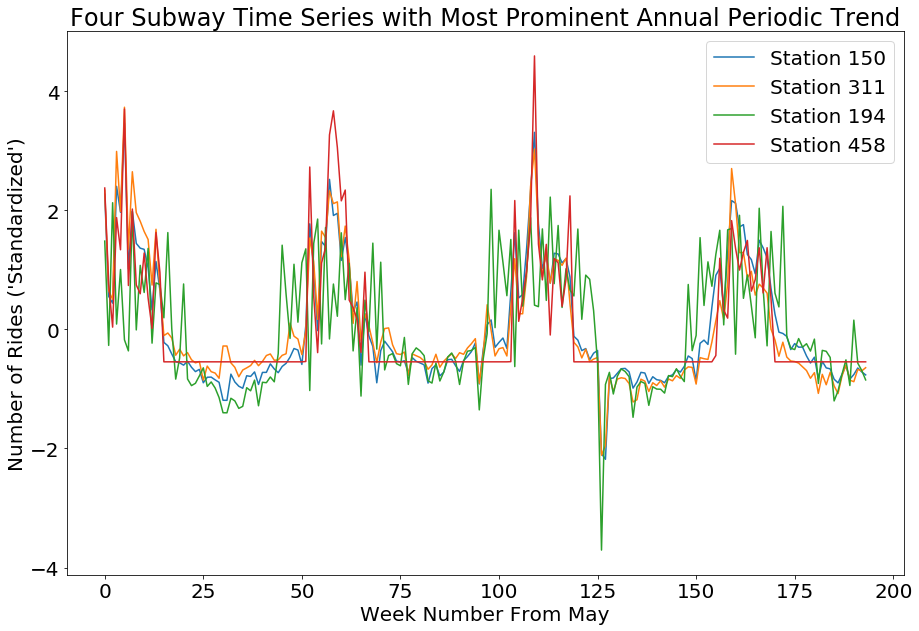

In [271]:
pl.figure(figsize=(15,10))
for j in peak4.index:
    pl.plot(mta_ar52[j], label = 'Station %s'%j)
pl.xlabel("Week Number From May")
pl.title ("Four Subway Time Series with Most Prominent Annual Periodic Trend")
pl.ylabel("Number of Rides ('Standardized')")
pl.legend()
pl.savefig('plots/Top4nan.png')

Here we see our final plot, where every year there is a very obvious cycle that occurs a few weeks after May begins and repeats every year at the same time. The most interesting station is #458 where it flatlines. This is likely due to NaN values collected at this station...or there are 0 riders throughout the year except in warm climate time.

In [254]:
# a look at that station
mta[458:]

array([  2.11580000e+05,   1.24351790e+07,   2.76809430e+07,
         1.56248220e+07,   2.66133180e+07,   3.52730000e+05,
         1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         3.10477600e+06,   3.54910600e+06,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

# Lets see if we find the next most periodic station is NaN

In [260]:
# turn into dataframe, sort and have just 4 stations
peak5 = pd.DataFrame(peak).sort(0,ascending=False).head(5)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


In [261]:
peak5

,0
150,9816.996078
311,9429.675639
194,7750.583021
458,6583.532063
0,6452.238200


In [ ]:
# We can manually remove station 458 

In [268]:
peak5.drop(458,inplace=True)

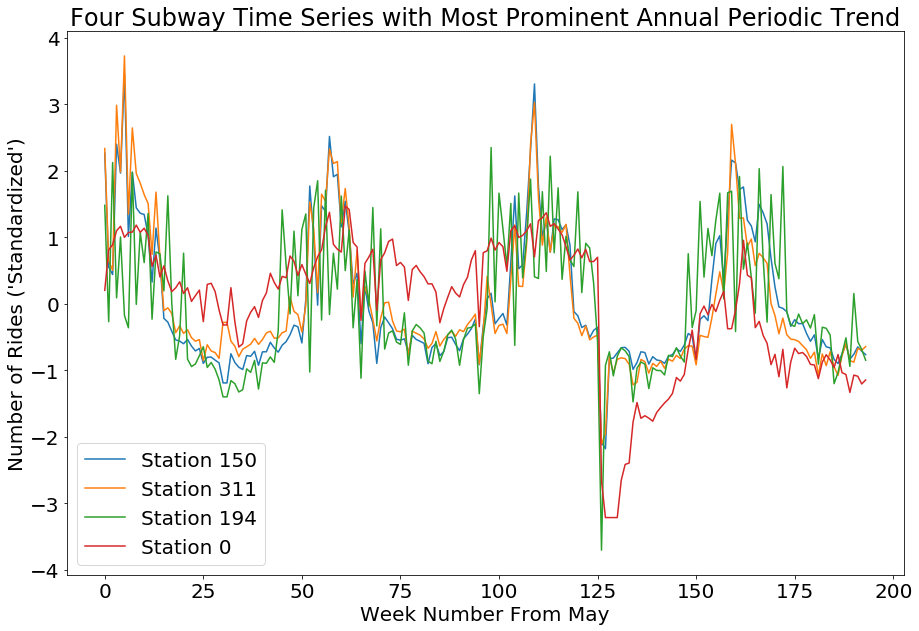

In [272]:
pl.figure(figsize=(15,10))
for j in peak5.index:
    pl.plot(mta_ar52[j], label = 'Station %s'%j)
pl.xlabel("Week Number From May")
pl.title ("Four Subway Time Series with Most Prominent Annual Periodic Trend")
pl.ylabel("Number of Rides ('Standardized')")
pl.legend()
pl.savefig('plots/Top4.png')

This is our final plot to find which stations exhibit the most periodicity on an annual basis. It is interesting to see such a yearly cycle where the peak is during the summer.

# Task 5: Extra Credit

Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:

are there distinct clusters?
do they reflect the card type or station?

To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead:

observation = (observation -observation.mean()) / observation.std() each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)

# Everything below is me calculating other cycles that might be stronger than those we see at 1 year, but not what the question is asking...which is to find the strongest annual periodicity

In [88]:
#we want at an annual period 
194/52

3.730769230769231

In [ ]:
# We want only 3 full years for our Fourier transformation, so lets take off the extra past 156 weeks

In [102]:
mta156 = mta[:, :157]

In [103]:
mta156.shape

(600, 157)

In [104]:
# make into dataframe so we can add the periodicity
df_mta156 = pd.DataFrame.from_records(mta156)

In [105]:
df_mta156.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,126878.0,149477.0,152383.0,160175.0,162641.0,156414.0,159156.0,159374.0,163285.0,159252.0,...,79927.0,94058.0,104629.0,88395.0,113814.0,118073.0,113264.0,119009.0,115030.0,121306.0
1,37306.0,46464.0,49359.0,44849.0,41509.0,35654.0,41989.0,41909.0,41214.0,41142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6606.0,6881.0,7229.0,5731.0,7032.0,5107.0,5497.0,5668.0,5555.0,6942.0,...,5312.0,5951.0,6029.0,7195.0,8259.0,8533.0,8830.0,8603.0,7752.0,6861.0
3,16378.0,17408.0,17595.0,14242.0,17589.0,13168.0,14510.0,14388.0,14221.0,17180.0,...,13986.0,14857.0,15385.0,20271.0,21583.0,23687.0,23428.0,23425.0,21339.0,18429.0
4,18564.0,19903.0,19948.0,16076.0,20283.0,14601.0,16151.0,16066.0,16205.0,19619.0,...,15669.0,16715.0,17277.0,19521.0,22762.0,23515.0,23503.0,23227.0,21275.0,18999.0


In [106]:
df_mta156.shape

(600, 157)

In [107]:
# we want to standardize along each station. Subtract mean/divide by std
df_mta156_st = ((df_mta156.T - df_mta156.mean(1)) / df_mta156.std(1)).T

In [108]:
df_mta156_st.head()

,0,1,2,3,4,5,6,7,8,9,...,147,148,149,150,151,152,153,154,155,156
0,0.048258,0.643034,0.719516,0.924591,0.989493,0.825607,0.897772,0.903510,1.006442,0.900299,...,-1.187432,-0.815522,-0.537307,-0.964565,-0.295570,-0.183479,-0.310045,-0.158844,-0.263566,-0.098390
1,0.671329,1.193500,1.358567,1.101416,0.910976,0.577135,0.938345,0.933783,0.894156,0.890050,...,-1.455786,-1.455786,-1.455786,-1.455786,-1.455786,-1.455786,-1.455786,-1.455786,-1.455786,-1.455786
2,-0.522470,-0.235765,0.127047,-1.434712,-0.078338,-2.085271,-1.678672,-1.500393,-1.618203,-0.172169,...,-1.871546,-1.205348,-1.124028,0.091599,1.200886,1.486548,1.796189,1.559527,0.672307,-0.256616
3,-0.682858,-0.342523,-0.280735,-1.388640,-0.282717,-1.743513,-1.300086,-1.340398,-1.395578,-0.417860,...,-1.473228,-1.185430,-1.010967,0.603475,1.036988,1.732196,1.646617,1.645626,0.956366,-0.005163
4,-0.584613,-0.032759,-0.014212,-1.610016,0.123854,-2.217922,-1.579106,-1.614138,-1.556850,-0.149806,...,-1.777757,-1.346659,-1.115037,-0.190196,1.145548,1.455889,1.450943,1.337193,0.532697,-0.405333


In [109]:
df_mta156_st.dropna(inplace=True)

In [110]:
df_mta156_st.shape

(470, 157)

In [112]:
# Lets turn it back into an array to look at in Fourier Space 
mta_ar156 = pd.DataFrame.as_matrix(df_mta156_st)

In [113]:
mta_ar156.shape

(470, 157)

In [ ]:
# 4. Fourier transform
# from the numpy package you will nees only the np.fft.rfft() to take the fourier transform

In [114]:
#j indicate imaginary: the second piece of mta entry is its complex component
np.fft.rfft(mta_ar156)

array([[  5.55111512e-15 +0.j        ,  -4.22008746e+01-25.1964698j ,
          7.44110960e+00-43.84724715j, ...,  -2.11064488e+00 -0.28722649j,
         -7.69029688e-02 -2.96787204j,   1.07581308e+00 +2.82636361j],
       [ -2.30926389e-14 +0.j        ,  -3.96216831e+01-80.63048234j,
          1.82522775e+01-34.5200071j , ...,   6.36375270e-01 +2.29717099j,
         -5.10836220e-01 -0.48338099j,   2.84497075e+00 +1.62406039j],
       [  1.99840144e-14 +0.j        ,  -3.58572312e+01 -4.81603387j,
          3.06895027e+01 -8.92186057j, ...,  -6.33175114e+00 -6.26879214j,
          4.58574431e-02 -9.97160403j,   1.21213750e+01 +2.44636546j],
       ..., 
       [  9.72555370e-14 +0.j        ,  -4.41457137e+01-14.77351888j,
          6.29039717e+00-23.49392147j, ...,  -2.12448427e+00 -0.67149341j,
          1.40371903e+00 -3.90583615j,   5.17959764e+00 +8.85526332j],
       [ -3.50830476e-14 +0.j        ,  -3.40921215e+01-41.80410545j,
          8.44836002e+00-44.03156959j, ...,  -2.45185

## To detect periodicity we use the "power spectrum": square (or absolute value) of the real part of the fourier transform

In [115]:
(np.fft.rfft(mta_ar156).real)**2

array([[  3.08148791e-29,   1.78091382e+03,   5.53701120e+01, ...,
          4.45482181e+00,   5.91406660e-03,   1.15737378e+00],
       [  5.33269972e-28,   1.56987777e+03,   3.33145633e+02, ...,
          4.04973484e-01,   2.60953644e-01,   8.09385859e+00],
       [  3.99360833e-28,   1.28574103e+03,   9.41845574e+02, ...,
          4.00910725e+01,   2.10290508e-03,   1.46927733e+02],
       ..., 
       [  9.45863947e-27,   1.94884404e+03,   3.95690966e+01, ...,
          4.51343341e+00,   1.97042712e+00,   2.68282317e+01],
       [  1.23082023e-27,   1.16227275e+03,   7.13747869e+01, ...,
          6.01160209e+00,   4.81727052e-01,   7.75403281e+00],
       [  2.48540489e-28,   2.75783105e+02,   4.22171576e+00, ...,
          6.15314547e-01,   5.24051942e-01,   3.79106105e+01]])

In [116]:
len(mta_ar156)

470

In [117]:
mta_ar156.shape

(470, 157)

In [120]:
fr[2:80]

array([  4.22171576e+00,   4.86481865e+02,   5.40931418e+01,
         4.54655181e+02,   4.41887352e+01,   1.76303511e+02,
         3.61902047e+02,   2.74824566e+01,   3.50907643e+02,
         6.46605020e+01,   1.01488029e+02,   3.12214903e+02,
         1.00124462e+01,   2.43028786e+02,   6.41714699e+01,
         5.80345157e+00,   2.44733778e+02,   1.38866271e+01,
         2.36560479e+02,   1.62832010e+02,   4.35017234e+00,
         7.67706022e+01,   9.50605932e-01,   9.97273121e+01,
         1.85864254e+02,   5.72170062e+00,   1.55931528e+02,
         7.72026945e+01,   4.09163822e+01,   1.63857058e+02,
         1.76670596e-03,   1.01817296e+02,   2.46391188e+02,
         4.93286018e+00,   5.47865984e+02,   2.02186269e+00,
         1.50214277e+02,   1.76639538e+02,   3.88283143e-01,
         2.39323812e+02,   4.85845557e+00,   3.48452672e+00,
         8.06969623e+01,   1.58080461e-02,   1.82493970e+02,
         1.34906634e+00,   7.49135895e-01,   1.09751969e+02,
         4.61755137e-01,

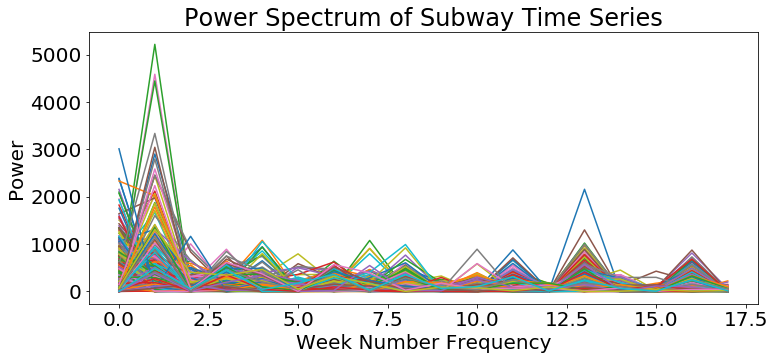

In [125]:
pl.figure(figsize=(12,5))
for i in range(len(mta_ar156)):
    fr=np.square((np.fft.rfft(mta_ar156[i]).real))
    pl.plot(fr[2:20])
    pl.xlabel("Week Number Frequency")
    pl.title ("Power Spectrum of Subway Time Series")
    pl.ylabel("Power")

Here it looks like there is a cycle every week! Makes sense, humans are habitual creatures and a work schedule has a frequency of a week. We also see a peak at around 13 weeks, which is about 3 full months, perhaps identifying a quarter in the year which would also make sense.

In [97]:
mta_ar.shape[1]

52

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Power')

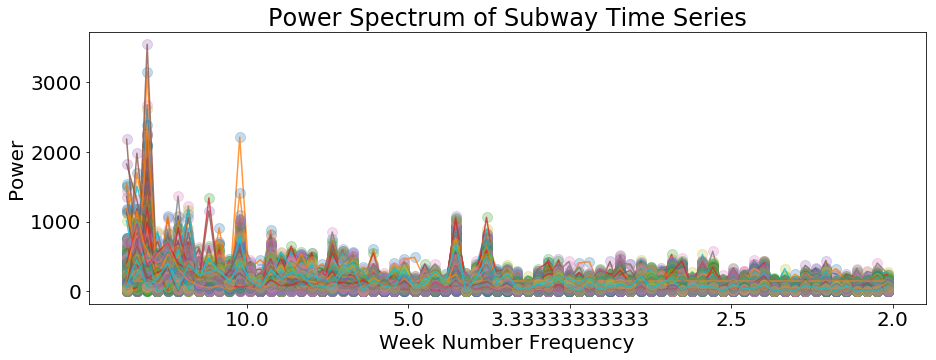

In [123]:
peak = []
N = mta_ar156.shape[1]
pl.figure(figsize=(12,5))
fig=pl.figure(figsize=(15,5))
for i in range(len(mta_ar156)):
    #fr=np.square((np.fft.rfft(mta_ar156[i]).real))
    f = np.abs(np.fft.rfft(mta_ar156[i]))**2   
    ax=fig.add_subplot(111)
    ax.plot(np.fft.rfftfreq(N, 1.0)[4:], (f[4:]), 'o', ms=10 , alpha= .25)
    ax.plot(np.fft.rfftfreq(N, 1.0)[4:], (f[4:]), '-' , alpha = .8)
    peak.append(f[4:].max())
    #pl.plot(fr[2:])
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Week Number Frequency")
pl.title ("Power Spectrum of Subway Time Series")
pl.ylabel("Power")

In [126]:
#pd.DataFrame
peak156 = pd.DataFrame(peak)

In [127]:
top4_156 = peak156.sort_values(by = 0 ,axis = 0, ascending = False).head(4)

In [128]:
top4_156

,0
282,3546.509705
150,3154.433752
168,2678.720858
29,2620.338727


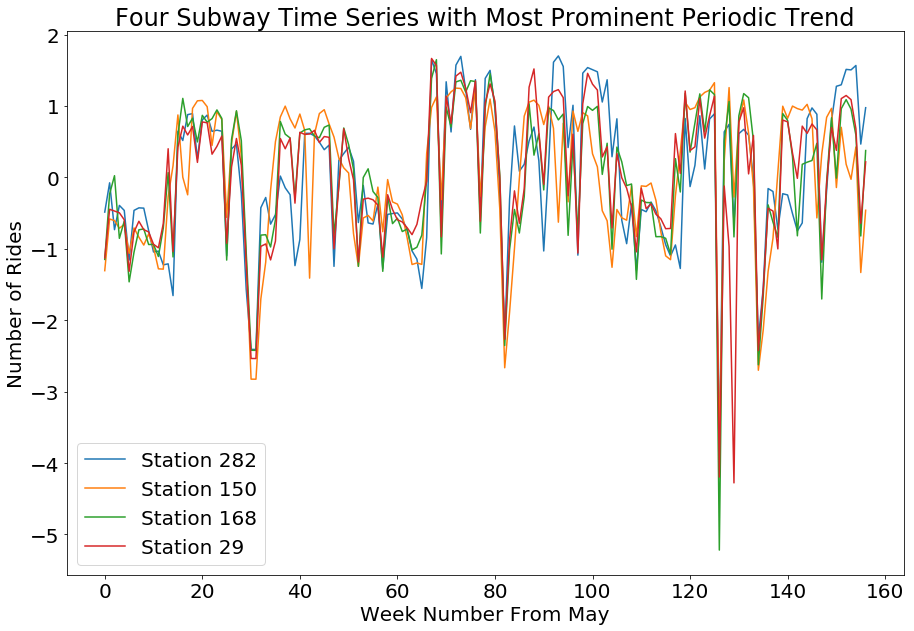

In [129]:
pl.figure(figsize=(15,10))
for j in top4_156.index:
    pl.plot(mta_ar156[j], label = 'Station %s'%j)
pl.xlabel("Week Number From May")
pl.title ("Four Subway Time Series with Most Prominent Periodic Trend")
pl.ylabel("Number of Rides")
pl.legend()

Here we see the 4 subway stations with the maximum value in the Fourier transformation. We see they each follow a pretty similar pattern with their highs and lows. 

## Find which stations show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

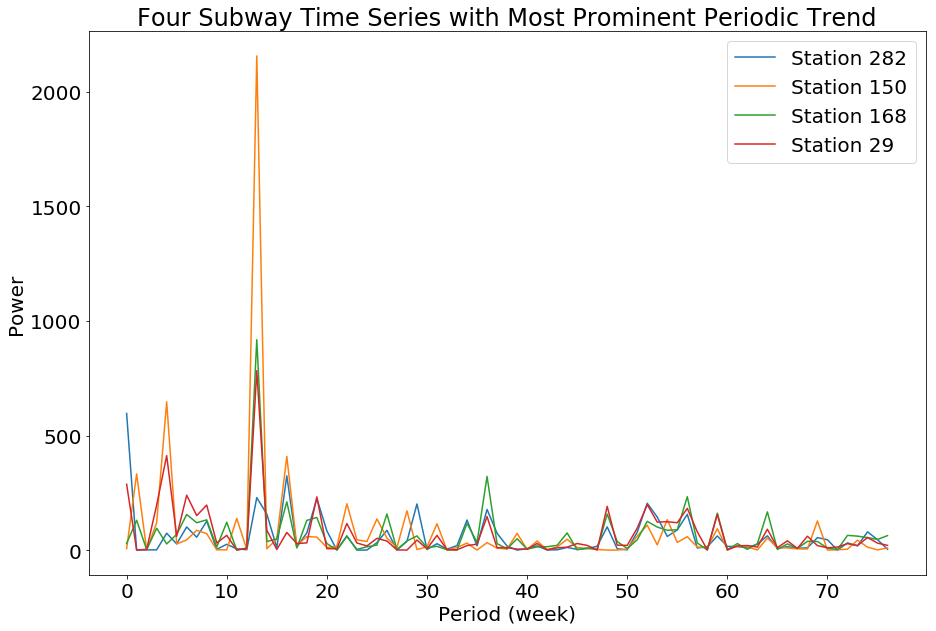

In [133]:
pl.figure(figsize=(15,10))
for j in top4_156.index:
    fr=np.square((np.fft.rfft(mta_ar156[j]).real))
    pl.plot(fr[2:], label = 'Station %s'%j)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (week)")
pl.title ("Four Subway Time Series with Most Prominent Periodic Trend")
pl.ylabel("Power")
pl.legend()

This is an interesting plot to see that every 13 weeks these four stations have the highest periodic trend. Maybe these stations are most used by those in the business world that operate on the quarterly basis where every three months there is a cycle in their daily routine.

# Now lets look at one 52 Week Period

In [13]:
# make into a dataframe
np.nansum(mta,axis=1).T.shape

(194, 600)

In [84]:
52*3

156

In [4]:
# transpose dataframe so we can add the periodicity
df_mta = pd.DataFrame.from_records(np.nansum(mta,axis=1))

In [32]:
df_mta.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,126878.0,149477.0,152383.0,160175.0,162641.0,156414.0,159156.0,159374.0,163285.0,159252.0,...,87973.0,83825.0,91001.0,80908.0,79891.0,69881.0,79550.0,78901.0,74591.0,76833.0
1,37306.0,46464.0,49359.0,44849.0,41509.0,35654.0,41989.0,41909.0,41214.0,41142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6606.0,6881.0,7229.0,5731.0,7032.0,5107.0,5497.0,5668.0,5555.0,6942.0,...,8268.0,5928.0,5656.0,7665.0,8377.0,7343.0,7743.0,8171.0,7907.0,6790.0
3,16378.0,17408.0,17595.0,14242.0,17589.0,13168.0,14510.0,14388.0,14221.0,17180.0,...,23450.0,16228.0,15586.0,21806.0,23534.0,20604.0,21370.0,22459.0,22773.0,19033.0
4,18564.0,19903.0,19948.0,16076.0,20283.0,14601.0,16151.0,16066.0,16205.0,19619.0,...,23025.0,18253.0,17293.0,21484.0,22516.0,20560.0,21942.0,23283.0,22987.0,21562.0


In [163]:
df_mta.shape

(600, 194)

In [5]:
# we want to standardize along each station. Subtract mean/divide by std
df_mta = ((df_mta.T - df_mta.mean(1)) / df_mta.std(1)).T

In [167]:
df_mta.shape

(194, 600)

In [6]:
#Transpose it
df_mta = df_mta.T

In [7]:
#Make the index into each annual period
df_mta.index = df_mta.index%52

In [8]:
df_mta.head(53)

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.202071,0.889935,-0.649826,-0.834317,-0.737333,-0.814121,-0.869427,-0.863463,-0.596344,-1.642393,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.811194,1.379618,-0.369790,-0.508762,-0.191135,-0.586676,-0.131820,-0.591457,-0.206278,-1.357357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.889521,1.534415,-0.015416,-0.449656,-0.172779,-0.372779,-0.085527,-0.410438,-0.312336,-1.315118,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.099543,1.293263,-1.540852,-1.509448,-1.752226,-1.732097,-1.479882,-1.477392,-1.563678,-1.354073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.166010,1.114671,-0.216024,-0.451552,-0.036128,-0.485432,0.145940,-0.454975,-0.282441,-1.252805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.998171,0.801602,-2.176280,-1.848910,-2.353900,-2.381989,-2.198972,-2.063068,-2.350927,-1.527766,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1.072077,1.140337,-1.779137,-1.424741,-1.721632,-1.812309,-1.452723,-1.494153,-1.677565,-1.347805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.077953,1.136060,-1.605005,-1.463302,-1.756305,-1.915693,-1.443465,-1.553056,-1.915306,-1.280753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.183368,1.098898,-1.720075,-1.516086,-1.699605,-1.896085,-1.486672,-1.471646,-1.762269,-1.319186,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.074665,1.095048,-0.307673,-0.580826,-0.306983,-0.608779,-0.192310,-0.635035,-0.528011,-1.275865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#group by the average of each index
df_mta = df_mta.groupby(df_mta.index).mean()

Text(0.5,1,'Quick Look at Perodicity')

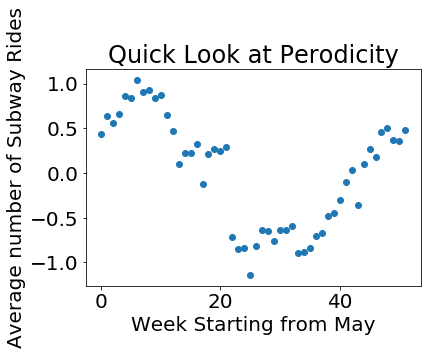

In [10]:
# a quick look at the periodicity
plt.scatter(df_mta.index,df_mta[0])
plt.xlabel('Week Starting from May')
plt.ylabel('Average number of Subway Rides')
plt.title('Quick Look at Perodicity')

In [11]:
# flip it back so we have the station as the index again
df_mta = df_mta.T

In [43]:
df_mta.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.433454,0.634365,0.562332,0.658678,0.858760,0.843774,1.043547,0.905747,0.930376,0.837743,...,0.031195,-0.362650,0.102236,0.270228,0.181344,0.458795,0.508452,0.372651,0.356048,0.475587
1,0.186919,0.501713,0.513797,0.467933,0.430824,0.172081,0.015572,-0.001164,-0.007246,-0.026843,...,0.183822,0.010470,0.132134,0.210842,0.154003,0.134076,0.250695,0.248254,0.197528,0.193571
2,-0.290616,0.038300,0.213704,-0.206096,-0.282724,-0.874874,-0.447182,-0.443618,-0.403649,-0.463220,...,0.289060,-0.850774,-0.522198,-0.916964,-0.487914,0.281253,0.676698,0.574188,0.235428,-0.002857
3,-0.308925,-0.062230,-0.209520,-0.477786,-0.334289,-0.690029,-0.366292,-0.434089,-0.534838,-0.495012,...,0.106843,-0.528463,-0.587885,-0.890051,-0.230934,0.415225,0.720340,0.470537,0.307760,0.141927
4,-0.442819,0.053002,0.215250,-0.216936,0.002012,-0.764868,-0.245490,-0.307391,-0.326053,-0.321464,...,0.102563,-1.020154,-0.715170,-0.852365,-0.729311,0.421825,0.717427,0.372331,0.041784,-0.041295


In [12]:
df_mta.dropna(inplace=True)

In [45]:
df_mta.head()

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,0.433454,0.634365,0.562332,0.658678,0.858760,0.843774,1.043547,0.905747,0.930376,0.837743,...,0.031195,-0.362650,0.102236,0.270228,0.181344,0.458795,0.508452,0.372651,0.356048,0.475587
1,0.186919,0.501713,0.513797,0.467933,0.430824,0.172081,0.015572,-0.001164,-0.007246,-0.026843,...,0.183822,0.010470,0.132134,0.210842,0.154003,0.134076,0.250695,0.248254,0.197528,0.193571
2,-0.290616,0.038300,0.213704,-0.206096,-0.282724,-0.874874,-0.447182,-0.443618,-0.403649,-0.463220,...,0.289060,-0.850774,-0.522198,-0.916964,-0.487914,0.281253,0.676698,0.574188,0.235428,-0.002857
3,-0.308925,-0.062230,-0.209520,-0.477786,-0.334289,-0.690029,-0.366292,-0.434089,-0.534838,-0.495012,...,0.106843,-0.528463,-0.587885,-0.890051,-0.230934,0.415225,0.720340,0.470537,0.307760,0.141927
4,-0.442819,0.053002,0.215250,-0.216936,0.002012,-0.764868,-0.245490,-0.307391,-0.326053,-0.321464,...,0.102563,-1.020154,-0.715170,-0.852365,-0.729311,0.421825,0.717427,0.372331,0.041784,-0.041295


In [71]:
df_mta.shape

(471, 52)

In [13]:
# Lets turn it back into an array to look at in Fourier Space 
mta_ar = pd.DataFrame.as_matrix(df_mta)

In [14]:
mta_ar.shape

(471, 52)

In [ ]:
# 4. Fourier transform
# from the numpy package you will nees only the np.fft.rfft() to take the fourier transform

In [15]:
#j indicate imaginary: the second piece of mta entry is its complex component
np.fft.rfft(mta_ar)

array([[  0.26706291 +0.j        ,  17.44647256-12.02439229j,
         -1.49787046 +0.10048283j, ...,  -0.94161443 +0.49460631j,
         -0.12905542 +0.08662473j,   1.17801716 +0.j        ],
       [  0.49700517 +0.j        ,   5.89947097 -0.71873984j,
          1.93051437 +2.52859039j, ...,   0.05593835 -0.1840926j ,
         -0.59824265 -0.26149189j,   0.76039026 +0.j        ],
       [  0.05126829 +0.j        ,  -5.27851019 +0.18283389j,
          1.88461718 +6.84540935j, ...,  -0.91211300 +0.15866506j,
          1.58132509 +0.4423061j ,   0.92182924 +0.j        ],
       ..., 
       [  0.05893142 +0.j        ,  11.52859807-11.78924004j,
         -4.69847939 +2.95522945j, ...,  -0.96546517 +0.34781977j,
         -0.90626670 +0.34620439j,   3.09254302 +0.j        ],
       [  0.56664740 +0.j        ,  10.64376113 -5.23979575j,
         -5.90191477 +2.8134672j , ...,  -0.72667027 +0.07806619j,
         -0.45896584 +0.15698607j,   0.35169561 +0.j        ],
       [ -0.47699700 +0.j  

## To detect periodicity we use the "power spectrum": square (or absolute value) of the real part of the fourier transform

In [16]:
(np.fft.rfft(mta_ar).real)**2

array([[  7.13225957e-02,   3.04379405e+02,   2.24361592e+00, ...,
          8.86637734e-01,   1.66553003e-02,   1.38772442e+00],
       [  2.47014140e-01,   3.48037578e+01,   3.72688574e+00, ...,
          3.12909877e-03,   3.57894273e-01,   5.78193344e-01],
       [  2.62843733e-03,   2.78626698e+01,   3.55178192e+00, ...,
          8.31950132e-01,   2.50058905e+00,   8.49769141e-01],
       ..., 
       [  3.47291281e-03,   1.32908574e+02,   2.20757085e+01, ...,
          9.32122987e-01,   8.21319336e-01,   9.56382236e+00],
       [  3.21089278e-01,   1.13289651e+02,   3.48325980e+01, ...,
          5.28049688e-01,   2.10649641e-01,   1.23689803e-01],
       [  2.27526136e-01,   6.46025616e+01,   1.75157133e+00, ...,
          6.17006848e-01,   1.81460539e+00,   7.69729913e+00]])

In [60]:
len(mta_ar)

471

In [81]:
mta_ar.shape

(471, 52)

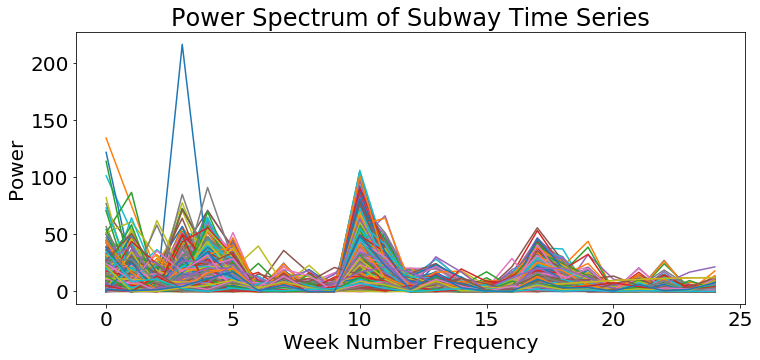

In [82]:
pl.figure(figsize=(12,5))
for i in range(len(mta_ar)):
    fr=np.square((np.fft.rfft(mta_ar[i]).real))
    pl.plot(fr[2:])
    pl.xlabel("Week Number Frequency")
    pl.title ("Power Spectrum of Subway Time Series")
    pl.ylabel("Power")

The x axis is the frequency, and it is a bit tricky: it runs from 0 (period of 0 week from May) to the maximum frequency which is 1/2 the number of samples: 52 here. That is because I need at least 2 points to describe a pattern

In [97]:
mta_ar.shape[1]

52

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'Power')

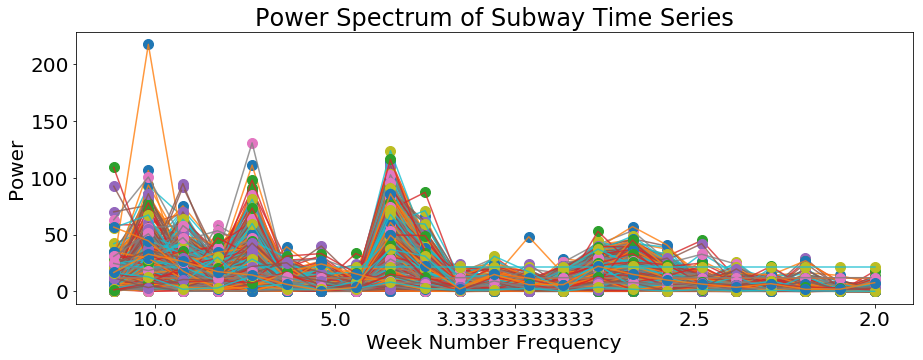

In [17]:
peak = []
N = mta_ar.shape[1]
pl.figure(figsize=(12,5))
fig=pl.figure(figsize=(15,5))
for i in range(len(mta_ar)):
    #fr=np.square((np.fft.rfft(mta_ar[i]).real))
    f = np.abs(np.fft.rfft(mta_ar[i]))**2   
    ax=fig.add_subplot(111)
    ax.plot(np.fft.rfftfreq(N, 1.0)[4:], (f[4:]), 'o', ms=10)
    ax.plot(np.fft.rfftfreq(N, 1.0)[4:], (f[4:]), '-' , alpha = .8)
    peak.append(f[4:].max())
    #pl.plot(fr[2:])
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Week Number Frequency")
pl.title ("Power Spectrum of Subway Time Series")
pl.ylabel("Power")

In [20]:
#pd.DataFrame
peak = pd.DataFrame(peak)

In [60]:
top4 = peak.sort_values(by = 0 ,axis = 0, ascending = False).head(4)

In [71]:
top4

,0
150,217.520351
333,130.787037
169,123.903721
441,116.244471


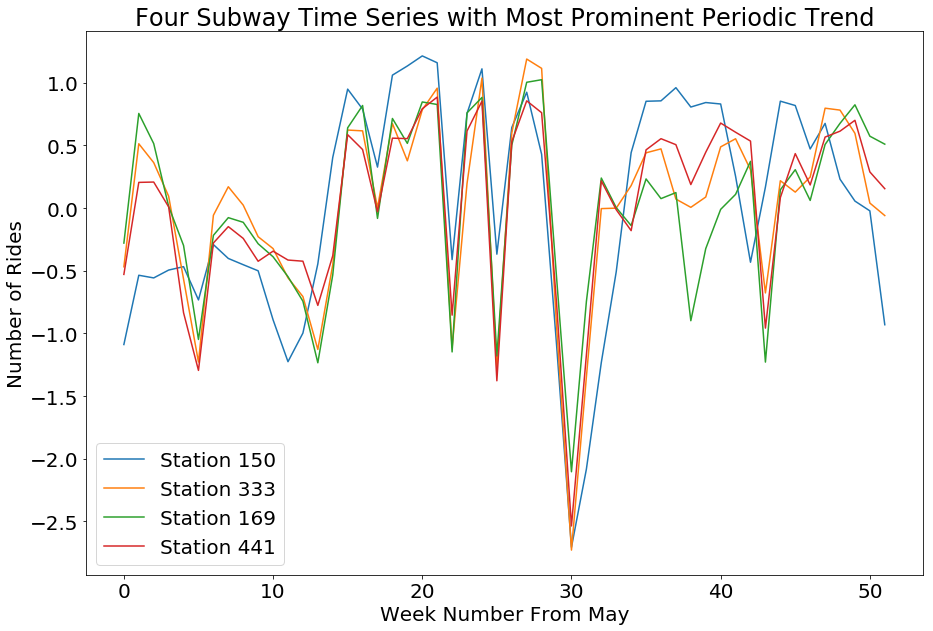

In [65]:
pl.figure(figsize=(15,10))
for j in top4.index:
    pl.plot(mta_ar[j], label = 'Station %s'%j)
pl.xlabel("Week Number From May")
pl.title ("Four Subway Time Series with Most Prominent Periodic Trend")
pl.ylabel("Number of Rides")
pl.legend()

Here we see the 4 subway stations with the maximum value in the Fourier transformation. 

## Find which stations show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

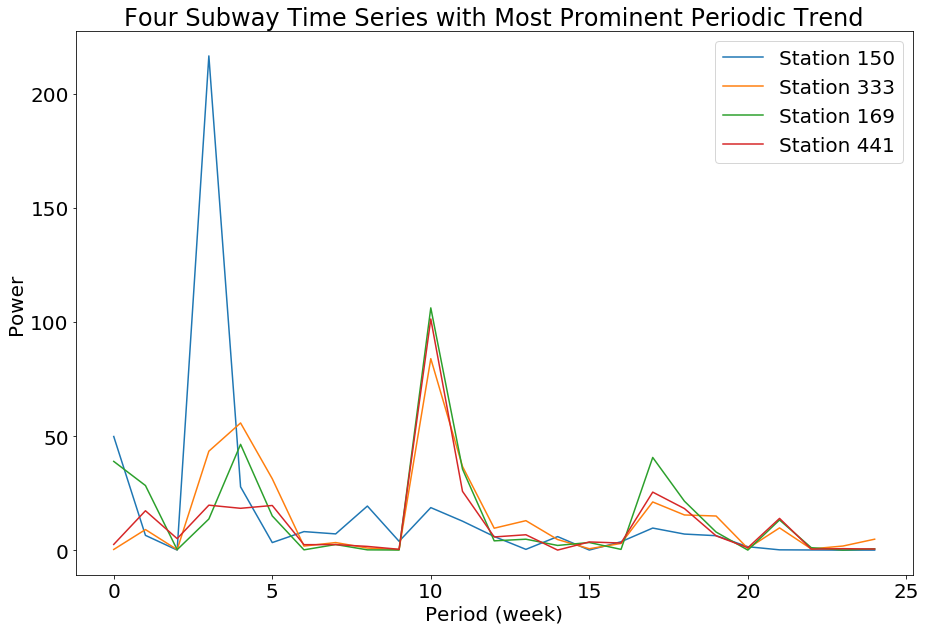

In [70]:
pl.figure(figsize=(15,10))
for j in top4.index:
    fr=np.square((np.fft.rfft(mta_ar[j]).real))
    pl.plot(fr[2:], label = 'Station %s'%j)
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("Period (week)")
pl.title ("Four Subway Time Series with Most Prominent Periodic Trend")
pl.ylabel("Power")
pl.legend()

This plot shows the frequency of the 4 most periodic stations, we see all of them have a relatively high peak about every 4 weeks, as well as every 10 weeks. Station 150 has the highest periodicity at about every 3 weeks there is a cycle in ridership. 

## Lets find out what causes this periodicity
Looking at the plain time series we see that there is a consistent dip at around every 10 week interval.

In [66]:
# Date Range
daterange = pd.date_range(start='2010-05-21', 
                          freq='W-FRI', periods=194)

In [80]:
daterange[:40]

DatetimeIndex(['2010-05-21', '2010-05-28', '2010-06-04', '2010-06-11',
               '2010-06-18', '2010-06-25', '2010-07-02', '2010-07-09',
               '2010-07-16', '2010-07-23', '2010-07-30', '2010-08-06',
               '2010-08-13', '2010-08-20', '2010-08-27', '2010-09-03',
               '2010-09-10', '2010-09-17', '2010-09-24', '2010-10-01',
               '2010-10-08', '2010-10-15', '2010-10-22', '2010-10-29',
               '2010-11-05', '2010-11-12', '2010-11-19', '2010-11-26',
               '2010-12-03', '2010-12-10', '2010-12-17', '2010-12-24',
               '2010-12-31', '2011-01-07', '2011-01-14', '2011-01-21',
               '2011-01-28', '2011-02-04', '2011-02-11', '2011-02-18'],
              dtype='datetime64[ns]', freq='W-FRI')

After 10 weeks, it is the end of July.  Then it is the start of October, then it is the start of December, after that it is beginning of February. Looking up holidays around these dates, we see Columbus Day in October, mayber Thanksgiving in November and Super Bowl in February. These are not very solid assumptions. Further research is necessary